In [14]:
import cv2
import numpy as np
from numpy import expand_dims
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Flatten, Conv2D, MaxPooling2D, Dense, Input)
from tensorflow.keras import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [15]:
image_shape = (160, 120, 3)

In [16]:
def data_aug(img):
    balls = []
    for i in range(-1,2):
        new_img = cv2.flip(img, i)
        new_img = tf.image.random_hue(new_img, 0.2, seed=None)
        imageNew = expand_dims(new_img, 0)
        new_img = np.array(tf.image.random_brightness(imageNew, 0.4, seed=None)).astype('uint8')
        balls.append(new_img.squeeze())
    return balls

def get_data():
    imgs, imgs_class = [], []
    paths = ['dataset/balls', 'dataset/no_balls']
    for path in paths:
        for file in tqdm(listdir(path)):
            if file.endswith('.jpg'):
                img = cv2.imread(path + '/' + file)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                if img.shape[1] > img.shape[0]:
                    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                img = cv2.resize(img, (image_shape[1], image_shape[0]))
                aug_imgs = data_aug(img)
                for img in aug_imgs:
                    img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
                    imgs.append(img)
                    imgs_class.append(1 if 'no' not in path else 0)
    return np.array(imgs), np.array(imgs_class)

In [17]:
imgs, img_classes = get_data()

100%|██████████| 314/314 [02:29<00:00,  2.10it/s]


In [18]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, img_classes, test_size=0.33)

In [19]:
input_layer = Input(image_shape)

base_layer = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation="relu", name='bl_1')(input_layer)
base_layer = MaxPooling2D(pool_size=(2,2), name='bl_2')(base_layer)

base_layer = Conv2D(filters=32, kernel_size=(3,3), activation="relu", name='bl_3')(base_layer)
base_layer = MaxPooling2D(pool_size=(2,2), name='bl_4')(base_layer)

base_layer = Conv2D(filters=64, kernel_size=(3,3), activation="relu", name='bl_5')(base_layer)
base_layer = MaxPooling2D(pool_size=(2,2), name='bl_6')(base_layer)

base_layer = Flatten(name='bl_7')(base_layer)

class_ = Dense(128, activation='relu')(base_layer)
class_ = Dense(1, activation="sigmoid", name="class_output")(class_)

model = Model(input_layer, outputs=[class_])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 120, 3)]     0         
                                                                 
 bl_1 (Conv2D)               (None, 160, 120, 16)      448       
                                                                 
 bl_2 (MaxPooling2D)         (None, 80, 60, 16)        0         
                                                                 
 bl_3 (Conv2D)               (None, 78, 58, 32)        4640      
                                                                 
 bl_4 (MaxPooling2D)         (None, 39, 29, 32)        0         
                                                                 
 bl_5 (Conv2D)               (None, 37, 27, 64)        18496     
                                                                 
 bl_6 (MaxPooling2D)         (None, 18, 13, 64)        0     

In [20]:
tf.keras.backend.clear_session()

model.compile(loss={"class_output":'binary_crossentropy'}, optimizer='Adam', metrics=['accuracy'])

In [21]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history = model.fit(train_imgs, {"class_output":train_labels},
            validation_data=(test_imgs, {"class_output":test_labels}),
            batch_size=64, epochs=20, shuffle=True, verbose=1, callbacks=[early_stopping_monitor])

Epoch 1/20
23/23 [==============================] - 17s 631ms/step - loss: 0.7370 - accuracy: 0.5571 - val_loss: 0.6619 - val_accuracy: 0.5626
Epoch 2/20
23/23 [==============================] - 13s 555ms/step - loss: 0.6124 - accuracy: 0.6556 - val_loss: 0.6099 - val_accuracy: 0.7151
Epoch 3/20
23/23 [==============================] - 13s 571ms/step - loss: 0.5485 - accuracy: 0.7420 - val_loss: 0.5525 - val_accuracy: 0.7597
Epoch 4/20
23/23 [==============================] - 13s 565ms/step - loss: 0.5197 - accuracy: 0.7704 - val_loss: 0.5263 - val_accuracy: 0.7712
Epoch 5/20
23/23 [==============================] - 13s 564ms/step - loss: 0.4879 - accuracy: 0.7817 - val_loss: 0.5026 - val_accuracy: 0.7842
Epoch 6/20
23/23 [==============================] - 13s 569ms/step - loss: 0.4549 - accuracy: 0.8016 - val_loss: 0.4735 - val_accuracy: 0.8014
Epoch 7/20
23/23 [==============================] - 13s 568ms/step - loss: 0.3965 - accuracy: 0.8214 - val_loss: 0.4457 - val_accuracy: 0.8072

[0.18616125]


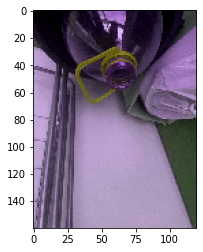

[0.18400148]


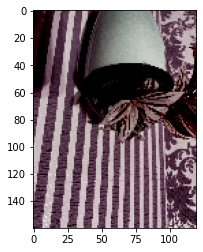

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.07269102]


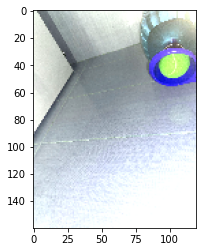

[0.42620113]


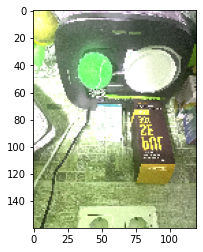

[0.6523925]


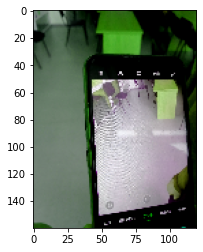

[0.9995395]


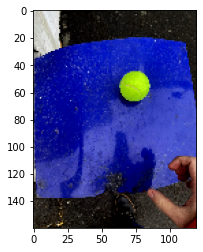

[0.3204986]


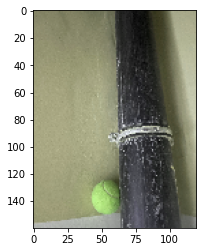

[0.16563126]


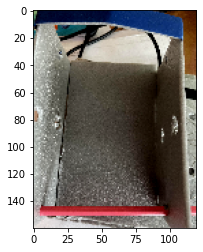

[0.59160405]


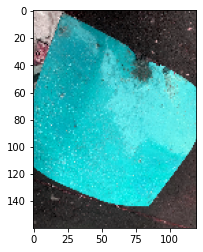

[0.98888355]


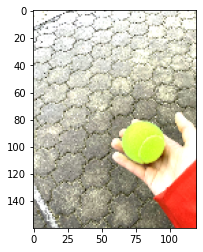

In [22]:
predictions = model.predict(test_imgs)
for i in range(len(test_imgs[:10])):
    print(predictions[i])
    plt.imshow(test_imgs[i])
    plt.show()

In [23]:
model.save('ball_classification_model.h5')